In [1]:
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 200)

from server2022.data.processed.prepare_data import create_df_2years_known, create_df_0years_known, create_df_1year_known

In [2]:
df_2years_known = create_df_2years_known()

In [3]:
df_2years_known

,"Макс. ПДЗ за 2019 год, дней","Сред. ПДЗ за 2019 год, дней","Кол-во просрочек свыше 5-ти дней за 2019 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.","Кол-во раз ПДЗ за 2019 год, шт.","Макс. ПДЗ за 2020 год, дней","Сред. ПДЗ за 2020 год, дней","Кол-во просрочек свыше 5-ти дней за 2020 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.","Кол-во раз ПДЗ за 2020 год, шт.",...,Факт. 52 (2020),Факт. 53 (2020),Факт. 54 (2020),Факт. 55 (2020),Факт. 56 (2020),Факт. 57 (2020),Факт. 58 (2020),Факт. 59 (2020),Факт. 60 (2020),Итого (2020)
Наименование ДП,,,,,,,,,,,,,,,,,,,,,
0,0,0.0,0,0.000000,0,10,6.400000,4,2.229696e+06,5,...,Х,Х,Н/Д,Х,Х,Х,Х,Х,Х,10.0
2,7,5.5,1,132825.299363,2,6,5.333333,2,3.759242e+06,3,...,Х,Х,Н/Д,Х,Х,Х,Х,Х,Х,40.0
4,2,2.0,0,0.000000,2,1,1.000000,0,0.000000e+00,2,...,Х,Х,10,Х,Х,Х,Х,Х,Х,20.0
5,0,0.0,0,0.000000,0,21,17.666667,5,4.486079e+06,6,...,Х,Х,10,Х,Х,Х,Х,10,Х,40.0
6,0,0.0,0,0.000000,0,0,0.000000,0,0.000000e+00,0,...,Х,Х,Н/Д,Х,Х,Х,Х,Х,Х,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,0,0.0,0,0.000000,0,4,1.750000,0,0.000000e+00,4,...,Х,Х,Н/Д,Х,Х,Х,Х,Х,Х,10.0
523,0,0.0,0,0.000000,0,0,0.000000,0,0.000000e+00,0,...,Х,Х,Н/Д,Х,Х,Н/Д,Н/Д,Х,Х,10.0
525,0,0.0,0,0.000000,0,0,0.000000,0,0.000000e+00,0,...,Х,Х,Н/Д,Х,Х,Х,Х,Х,Х,0.0


In [2]:
df_0 = create_df_0years_known()

(array([671.,  90.,  28.,   6.,   6.,   6.,   6.,   5.,   2.,   4.]),
 array([  0.,  37.,  74., 111., 148., 185., 222., 259., 296., 333., 370.]),
 <BarContainer object of 10 artists>)

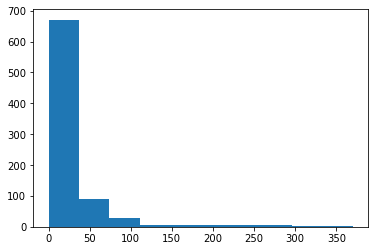

In [7]:
plt.hist(df_0['Итого'])

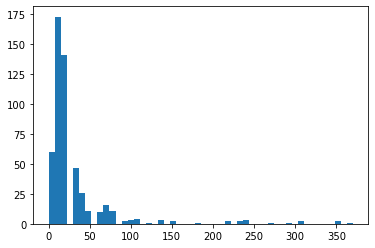

In [15]:
_ = plt.hist(df_0[df_0['year'] == '2020']['Итого'], bins=50)

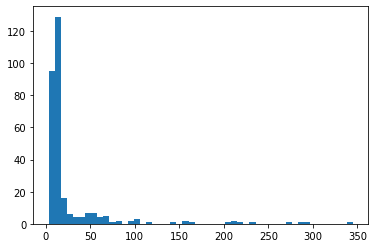

In [16]:
_ = plt.hist(df_0[df_0['year'] == '2021']['Итого'], bins=50)

In [3]:
df_0

,Наименование ДП,"-3, Нематериальные активы, RUB","-2, Нематериальные активы, RUB","-1, Нематериальные активы, RUB","-3, Основные средства , RUB","-2, Основные средства , RUB","-1, Основные средства , RUB","-3, Внеоборотные активы, RUB","-2, Внеоборотные активы, RUB","-1, Внеоборотные активы, RUB","-3, Дебиторская задолженность, RUB","-2, Дебиторская задолженность, RUB","-1, Дебиторская задолженность, RUB","-3, Оборотные активы, RUB","-2, Оборотные активы, RUB","-1, Оборотные активы, RUB","-3, Уставный капитал , RUB","-2, Уставный капитал , RUB","-1, Уставный капитал , RUB","-3, Капитал и резервы, RUB","-2, Капитал и резервы, RUB","-1, Капитал и резервы, RUB","-3, Заёмные средства (долгосрочные), RUB","-2, Заёмные средства (долгосрочные), RUB","-1, Заёмные средства (долгосрочные), RUB","-3, Долгосрочные обязательства, RUB","-2, Долгосрочные обязательства, RUB","-1, Долгосрочные обязательства, RUB","-3, Заёмные средства (краткосрочные), RUB","-2, Заёмные средства (краткосрочные), RUB","-1, Заёмные средства (краткосрочные), RUB","-3, Кредиторская задолженность, RUB","-2, Кредиторская задолженность, RUB","-1, Кредиторская задолженность, RUB","-3, Краткосрочные обязательства, RUB","-2, Краткосрочные обязательства, RUB","-1, Краткосрочные обязательства, RUB","-3, Выручка, RUB","-2, Выручка, RUB","-1, Выручка, RUB","-3, Себестоимость продаж, RUB","-2, Себестоимость продаж, RUB","-1, Себестоимость продаж, RUB","-3, Прибыль (убыток) до налогообложения , RUB","-2, Прибыль (убыток) до налогообложения , RUB","-1, Прибыль (убыток) до налогообложения , RUB","-3, Прибыль (убыток) от продажи, RUB","-2, Прибыль (убыток) от продажи, RUB","-1, Прибыль (убыток) от продажи, RUB",year,binary_target,Факт. 1,Факт. 2,Факт. 3,Факт. 7,Факт. 12,Факт. 14,Факт. 15,Факт. 16,Факт. 20,Факт. 21,Факт. 23,Факт. 24,Факт. 27,Факт. 28,Факт. 29,Факт. 30,Факт. 31,Факт. 32,Факт. 33,Факт. 37,Факт. 39,Факт. 40,Факт. 41,Факт. 42,Факт. 46,Факт. 48,Факт. 49,Факт. 50,Факт. 51,Факт. 54,Факт. 55,Факт. 56,Факт. 57,Факт. 58,Факт. 59,Факт. 60,Итого,"-4, Нематериальные активы, RUB","-4, Основные средства , RUB","-4, Внеоборотные активы, RUB","-4, Дебиторская задолженность, RUB","-4, Оборотные активы, RUB","-4, Уставный капитал , RUB","-4, Капитал и резервы, RUB","-4, Заёмные средства (долгосрочные), RUB","-4, Долгосрочные обязательства, RUB","-4, Заёмные средства (краткосрочные), RUB","-4, Кредиторская задолженность, RUB","-4, Краткосрочные обязательства, RUB","-4, Выручка, RUB","-4, Себестоимость продаж, RUB","-4, Прибыль (убыток) до налогообложения , RUB","-4, Прибыль (убыток) от продажи, RUB"
0,0,2.895541e+06,6.245860e+06,9.050955e+06,1.889724e+09,1.803724e+09,2.145239e+09,1.928685e+09,1.880842e+09,2.440078e+09,3.583766e+09,3.683359e+09,3.475461e+09,5.159380e+09,5.897326e+09,6.077448e+09,6.294000e+08,6.294000e+08,6.294000e+08,2.673020e+09,2.971017e+09,2.289274e+09,0.000000e+00,0.000000e+00,0.000000e+00,2.498777e+08,2.589732e+08,2.712210e+08,0.000000e+00,0.000000e+00,3.923917e+08,4.080056e+09,4.452922e+09,5.476906e+09,4.165168e+09,4.548178e+09,5.957031e+09,2.667698e+10,4.162693e+10,3.703952e+10,2.156814e+10,3.335443e+10,3.438313e+10,3.179697e+09,6.167667e+09,7.461828e+08,3.280355e+09,6.200120e+09,8.716191e+08,2019,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.000000e+00,3.885350e+04,3.439490e+04,1.448108e+08,1.487153e+08,1.526427e+08,1.456783e+08,1.497987e+08,1.538924e+08,5.584777e+07,4.678217e+07,1.563478e+08,1.489153e+08,1.898987e+08,2.914637e+08,1.345860e+06,1.345860e+06,1.345860e+06,2.726650e+08,2.774083e+08,3.106586e+08,0.000000e+00,0.000000e+00,0.000000e+00,3.108280e+06,4.528025e+06,5.033758e+06,9.745223e+06,4.760637e+07,6.349873e+07,9.075159e+06,1.015478e+07,6.616497e+07,1.882038e+07,5.776115e+07,1.296637e+08,2.554898e+08,2.573669e+08,5.434306e+08,2.056815e+08,2.055325e+08,4.169796e+08,1.212357e

In [4]:
len([x for x in df_0.columns.tolist() if x.startswith('Факт')])

36

In [4]:
q = "asd"

In [ ]:
q.startswith

In [7]:
df_0 = create_df_0years_known()

In [8]:
df_0

,Наименование ДП,"-3, Нематериальные активы, RUB","-2, Нематериальные активы, RUB","-1, Нематериальные активы, RUB","-3, Основные средства , RUB","-2, Основные средства , RUB","-1, Основные средства , RUB","-3, Внеоборотные активы, RUB","-2, Внеоборотные активы, RUB","-1, Внеоборотные активы, RUB","-3, Дебиторская задолженность, RUB","-2, Дебиторская задолженность, RUB","-1, Дебиторская задолженность, RUB","-3, Оборотные активы, RUB","-2, Оборотные активы, RUB","-1, Оборотные активы, RUB","-3, Уставный капитал , RUB","-2, Уставный капитал , RUB","-1, Уставный капитал , RUB","-3, Капитал и резервы, RUB","-2, Капитал и резервы, RUB","-1, Капитал и резервы, RUB","-3, Заёмные средства (долгосрочные), RUB","-2, Заёмные средства (долгосрочные), RUB","-1, Заёмные средства (долгосрочные), RUB","-3, Долгосрочные обязательства, RUB","-2, Долгосрочные обязательства, RUB","-1, Долгосрочные обязательства, RUB","-3, Заёмные средства (краткосрочные), RUB","-2, Заёмные средства (краткосрочные), RUB","-1, Заёмные средства (краткосрочные), RUB","-3, Кредиторская задолженность, RUB","-2, Кредиторская задолженность, RUB","-1, Кредиторская задолженность, RUB","-3, Краткосрочные обязательства, RUB","-2, Краткосрочные обязательства, RUB","-1, Краткосрочные обязательства, RUB","-3, Выручка, RUB","-2, Выручка, RUB","-1, Выручка, RUB","-3, Себестоимость продаж, RUB","-2, Себестоимость продаж, RUB","-1, Себестоимость продаж, RUB","-3, Прибыль (убыток) до налогообложения , RUB","-2, Прибыль (убыток) до налогообложения , RUB","-1, Прибыль (убыток) до налогообложения , RUB","-3, Прибыль (убыток) от продажи, RUB","-2, Прибыль (убыток) от продажи, RUB","-1, Прибыль (убыток) от продажи, RUB",year,binary_target,Факт. 1,Факт. 2,Факт. 3,Факт. 4,Факт. 5,Факт. 6,Факт. 7,Факт. 8,Факт. 9,Факт. 10,Факт. 11,Факт. 12,Факт. 13,Факт. 14,Факт. 15,Факт. 16,Факт. 17,Факт. 18,Факт. 19,Факт. 20,Факт. 21,Факт. 22,Факт. 23,Факт. 24,Факт. 25,Факт. 26,Факт. 27,Факт. 28,Факт. 29,Факт. 30,Факт. 31,Факт. 32,Факт. 33,Факт. 34,Факт. 35,Факт. 36,Факт. 37,Факт. 38,Факт. 39,Факт. 40,Факт. 41,Факт. 42,Факт. 43,Факт. 44,Факт. 45,Факт. 46,Факт. 47,Факт. 48,Факт. 49,Факт. 50,Факт. 51,Факт. 52,Факт. 53,Факт. 54,Факт. 55,Факт. 56,Факт. 57,Факт. 58,Факт. 59,Факт. 60,Итого,"-4, Нематериальные активы, RUB","-4, Основные средства , RUB","-4, Внеоборотные активы, RUB","-4, Дебиторская задолженность, RUB","-4, Оборотные активы, RUB","-4, Уставный капитал , RUB","-4, Капитал и резервы, RUB","-4, Заёмные средства (долгосрочные), RUB","-4, Долгосрочные обязательства, RUB","-4, Заёмные средства (краткосрочные), RUB","-4, Кредиторская задолженность, RUB","-4, Краткосрочные обязательства, RUB","-4, Выручка, RUB","-4, Себестоимость продаж, RUB","-4, Прибыль (убыток) до налогообложения , RUB","-4, Прибыль (убыток) от продажи, RUB","Оценка потенциала контрагента 1, руб.","Оценка потенциала контрагента 2, руб.",Статус,"-5, Нематериальные активы, RUB","-5, Основные средства , RUB","-5, Внеоборотные активы, RUB","-5, Дебиторская задолженность, RUB","-5, Оборотные активы, RUB","-5, Уставный капитал , RUB","-5, Капитал и резервы, RUB","-5, Заёмные средства (долгосрочные), RUB","-5, Долгосрочные обязательства, RUB","-5, Заёмные средства (краткосрочные), RUB","-5, Кредиторская задолженность, RUB","-5, Краткосрочные обязательства, RUB","-5, Выручка, RUB","-5, Себестоимость продаж, RUB","-5, Прибыль (убыток) до налогообложения , RUB","-5, Прибыль (убыток) от продажи, RUB"
0,0,2.895541e+06,6.245860e+06,9.050955e+06,1.889724e+09,1.803724e+09,2.145239e+09,1.928685e+09,1.880842e+09,2.440078e+09,3.583766e+09,3.683359e+09,3.475461e+09,5.159380e+09,5.897326e+09,6.077448e+09,6.294000e+08,6.294000e+08,6.294000e+08,2.673020e+09,2.971017e+09,2.289274e+09,0.000000e+00,0.000000e+00,0.000000e+00,2.498777e+08,2.589732e+08,2.712210e+08,0.000000e+00,0.000000e+00,3.923917e+08,4.080056e+09,4.452922e+09,5.476906e+09,4.165168e+09,4.548178e+09,5.957031e+09,2.667698e+10,4.162693e+10,3.703952e+10,2.156814e+10,3.335443e+10,3.438313e+10,3.179

In [2]:
df_1 = create_df_1year_known()

In [3]:
df_1

,Наименование ДП,Факт. 1,Факт. 2,Факт. 3,Факт. 4,Факт. 5,Факт. 6,Факт. 7,Факт. 8,Факт. 9,Факт. 10,Факт. 11,Факт. 12,Факт. 13,Факт. 14,Факт. 15,Факт. 16,Факт. 17,Факт. 18,Факт. 19,Факт. 20,Факт. 21,Факт. 22,Факт. 23,Факт. 24,Факт. 25,Факт. 26,Факт. 27,Факт. 28,Факт. 29,Факт. 30,Факт. 31,Факт. 32,Факт. 33,Факт. 34,Факт. 35,Факт. 36,Факт. 37,Факт. 38,Факт. 39,Факт. 40,Факт. 41,Факт. 42,Факт. 43,Факт. 44,Факт. 45,Факт. 46,Факт. 47,Факт. 48,Факт. 49,Факт. 50,Факт. 51,Факт. 52,Факт. 53,Факт. 54,Факт. 55,Факт. 56,Факт. 57,Факт. 58,Факт. 59,Факт. 60,Итого,"-4, Нематериальные активы, RUB","-3, Нематериальные активы, RUB","-2, Нематериальные активы, RUB","-1, Нематериальные активы, RUB","-4, Основные средства , RUB","-3, Основные средства , RUB","-2, Основные средства , RUB","-1, Основные средства , RUB","-4, Внеоборотные активы, RUB","-3, Внеоборотные активы, RUB","-2, Внеоборотные активы, RUB","-1, Внеоборотные активы, RUB","-4, Дебиторская задолженность, RUB","-3, Дебиторская задолженность, RUB","-2, Дебиторская задолженность, RUB","-1, Дебиторская задолженность, RUB","-4, Оборотные активы, RUB","-3, Оборотные активы, RUB","-2, Оборотные активы, RUB","-1, Оборотные активы, RUB","-4, Уставный капитал , RUB","-3, Уставный капитал , RUB","-2, Уставный капитал , RUB","-1, Уставный капитал , RUB","-4, Капитал и резервы, RUB","-3, Капитал и резервы, RUB","-2, Капитал и резервы, RUB","-1, Капитал и резервы, RUB","-4, Заёмные средства (долгосрочные), RUB","-3, Заёмные средства (долгосрочные), RUB","-2, Заёмные средства (долгосрочные), RUB","-1, Заёмные средства (долгосрочные), RUB","-4, Долгосрочные обязательства, RUB","-3, Долгосрочные обязательства, RUB","-2, Долгосрочные обязательства, RUB","-1, Долгосрочные обязательства, RUB","-4, Заёмные средства (краткосрочные), RUB","-3, Заёмные средства (краткосрочные), RUB",...,"-1, Выручка, RUB","-4, Себестоимость продаж, RUB","-3, Себестоимость продаж, RUB","-2, Себестоимость продаж, RUB","-1, Себестоимость продаж, RUB","-4, Прибыль (убыток) до налогообложения , RUB","-3, Прибыль (убыток) до налогообложения , RUB","-2, Прибыль (убыток) до налогообложения , RUB","-1, Прибыль (убыток) до налогообложения , RUB","-4, Прибыль (убыток) от продажи, RUB","-3, Прибыль (убыток) от продажи, RUB","-2, Прибыль (убыток) от продажи, RUB","-1, Прибыль (убыток) от продажи, RUB",year,binary_target,"Макс. ПДЗ за -1 год, дней","Сред. ПДЗ за -1 год, дней","Кол-во просрочек свыше 5-ти дней за -1 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за -1 год, руб.","Кол-во раз ПДЗ за -1 год, шт.","Оценка потенциала контрагента 1, руб.","Оценка потенциала контрагента 2, руб.",Статус,"-5, Нематериальные активы, RUB","-5, Основные средства , RUB","-5, Внеоборотные активы, RUB","-5, Дебиторская задолженность, RUB","-5, Оборотные активы, RUB","-5, Уставный капитал , RUB","-5, Капитал и резервы, RUB","-5, Заёмные средства (долгосрочные), RUB","-5, Долгосрочные обязательства, RUB","-5, Заёмные средства (краткосрочные), RUB","-5, Кредиторская задолженность, RUB","-5, Краткосрочные обязательства, RUB","-5, Выручка, RUB","-5, Себестоимость продаж, RUB","-5, Прибыль (убыток) до налогообложения , RUB","-5, Прибыль (убыток) от продажи, RUB",Факт. 1 (-1),Факт. 2 (-1),Факт. 3 (-1),Факт. 4 (-1),Факт. 5 (-1),Факт. 6 (-1),Факт. 7 (-1),Факт. 8 (-1),Факт. 9 (-1),Факт. 10 (-1),Факт. 11 (-1),Факт. 12 (-1),Факт. 13 (-1),Факт. 14 (-1),Факт. 15 (-1),Факт. 16 (-1),Факт. 17 (-1),Факт. 18 (-1),Факт. 19 (-1),Факт. 20 (-1),Факт. 21 (-1),Факт. 22 (-1),Факт. 23 (-1),Факт. 24 (-1),Факт. 25 (-1),Факт. 26 (-1),Факт. 27 (-1),Факт. 28 (-1),Факт. 29 (-1),Факт. 30 (-1),Факт. 31 (-1),Факт. 32 (-1),Факт. 33 (-1),Факт. 34 (-1),Факт. 35 (-1),Факт. 36 (-1),Факт. 37 (-1),Факт. 38 (-1),Факт. 39 (-1),Факт. 40 (-1),Факт. 41 (-1),Факт. 42 (-1),Факт. 43 (-1),Факт. 44 (-1),Факт. 45 (-1),Факт. 46 (-1),Факт. 47 (-1),Факт. 48 (-1),Факт. 49 (-1),Факт. 50 (-1),Факт. 51 (-1),Факт. 52 (-1),Факт. 53 (-1),Факт. 54 (-1),Факт. 55 (-1),Факт. 56 (-1),Факт. 57 (-1),Факт. 58 (-1),Факт. 59 (-1)